In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sklearn.metrics as m
from matplotlib import pyplot
from keras import backend as K

Using TensorFlow backend.


In [22]:
data_path = 'data/flat_data.npy'
names_path = 'data/flat_names.npy'
data_path = 'data/flat_data_extra.npy'
names_path = 'data/flat_names_extra.npy'

# load data from .npy files into numpy arrays
data = np.load(data_path)
names = np.load(names_path)
samples = len(data)
time_steps = 20
features = 107


X = data[:,2:].reshape((samples, time_steps, features))
Y = data[:, 1:2].reshape((samples))


In [23]:
train_X, test_X, train_Y, test_Y, train_names, test_names = train_test_split(X, Y, names, test_size=0.30, random_state=42, stratify=Y)

In [24]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

unique, counts = np.unique(Y, return_counts=True)
class_weight={
    1: counts[0] / counts[1] * 1,
    0: 1
}
class_weight

{1: 2.2337662337662336, 0: 1}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               83200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 83,301
Trainable params: 83,301
Non-trainable params: 0
_________________________________________________________________
None


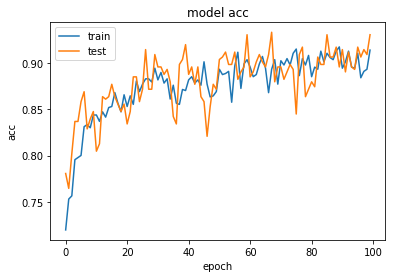

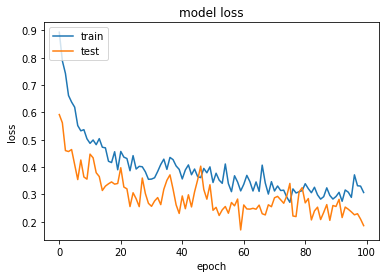

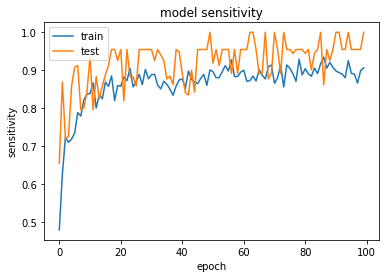

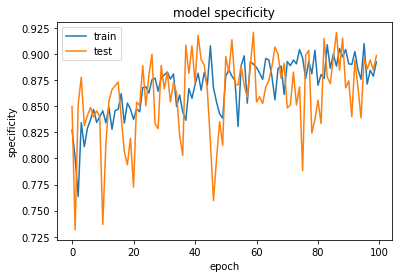

In [25]:
# build LSTM layers
model = Sequential()
model.add(LSTM(100, dropout=0.2, input_shape=(time_steps, features)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', specificity, sensitivity])
print(model.summary())
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=10, verbose=0, class_weight=class_weight)

def plotHistory(history, metricName):
    # summarize history 
    pyplot.plot(history.history[metricName])
    pyplot.plot(history.history['val_'+metricName])
    pyplot.title('model '+metricName)
    pyplot.ylabel(metricName)
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
plotHistory(history, 'acc')
plotHistory(history, 'loss')
plotHistory(history, 'sensitivity')
plotHistory(history, 'specificity')

In [26]:

# score model and log accuracy and parameters
loss, accuracy, specificity, sensitivity = model.evaluate(test_X, test_Y, verbose=0)
yhat = model.predict_classes(test_X)[:, 0]

print("Accuracy: %.2f%%" % (accuracy*100))
print("Specificity: %.2f%%" % (specificity*100))
print("Sensitivity (Recall): %.2f%%" % (sensitivity*100))
print('Confusion Matrix\n', m.confusion_matrix(test_Y, yhat))

false_positives = np.logical_and(test_Y != yhat, yhat == 1)
false_negatives = np.logical_and(test_Y != yhat, yhat == 0)

print('False Positives\n', test_names[false_positives])
print('False Negatives\n', test_names[false_negatives])

Accuracy: 93.05%
Specificity: 89.79%
Sensitivity (Recall): 100.00%
Confusion Matrix
 [[232  26]
 [  0 116]]
False Positives
 ['Kevin Johnson' 'Johnny Newman' 'Jeff Hornacek' 'Vlade Divac'
 'LeBron James' 'Tyrone Corbin' 'Rony Seikaly' 'Zach Randolph'
 'Jim Paxson' 'Jason Kidd' 'Joe Barry' 'Andrew Toney' 'Derrick Rose'
 'Dirk Nowitzki' 'Ricky Pierce' 'Darwin Cook' 'Bryant Reeves'
 'Armen Gilliam' 'Charles Oakley' 'Ray Allen' 'Gus Williams'
 'Purvis Short' 'Paul Pierce' 'LaMarcus Aldridge' 'Rasheed Wallace'
 'Chris Paul']
False Negatives
 []


ROC_AUC: 0.988


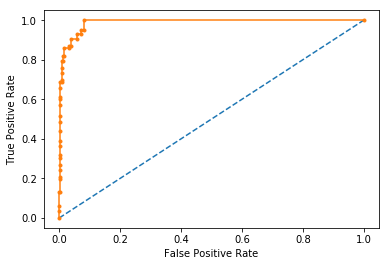

f1=0.899 auc=0.964 ap=0.965


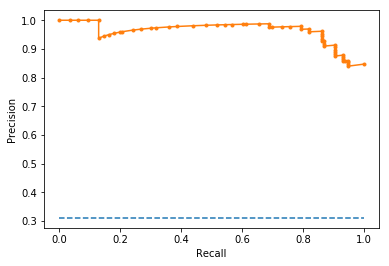

In [27]:


probs = model.predict(test_X)


# calculate AUC
roc = m.roc_auc_score(test_Y, probs)
print('ROC_AUC: %.3f' % roc)
# calculate roc curve
fpr, tpr, thresholds = m.roc_curve(test_Y, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the plot
pyplot.show()



precision, recall, thresholds = m.precision_recall_curve(test_Y, probs)
# calculate F1 score
f1 = m.f1_score(test_Y, yhat)
# calculate precision-recall AUC
auc = m.auc(recall, precision)
# calculate average precision score
ap = m.average_precision_score(test_Y, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
noskill_precision = len(test_Y[test_Y == 1]) / len(test_Y)
pyplot.plot([0, 1], [noskill_precision, noskill_precision], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the plot
pyplot.show()